In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy import stats
import six

In [2]:
#SKIP - Function for styling and exporting df as PNG
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

# Dataset 1 - Apple Quality
https://www.kaggle.com/datasets/nelgiriyewithana/apple-quality

In [3]:
df_apple_orig = pd.read_csv("data1/apple_quality.csv").iloc[:-1].drop('A_id', axis=1) #drop last row as it does not contain relevent data
df_apple_orig['Acidity'] = df_apple_orig['Acidity'].astype('float64')
df_apple_orig.head(2)

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.32984,-0.491590,good
1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.86753,-0.722809,good


In [4]:
len(df_apple_orig) #checking dataset length

4000

## Preprocessing Dataset 1
### Checking for missing values and column datatypes

In [5]:
df_apple_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Size         4000 non-null   float64
 1   Weight       4000 non-null   float64
 2   Sweetness    4000 non-null   float64
 3   Crunchiness  4000 non-null   float64
 4   Juiciness    4000 non-null   float64
 5   Ripeness     4000 non-null   float64
 6   Acidity      4000 non-null   float64
 7   Quality      4000 non-null   object 
dtypes: float64(7), object(1)
memory usage: 250.1+ KB


### Checking Target Variable

In [6]:
#Identify target column cardinality.
df_apple_orig['Quality'].unique()

array(['good', 'bad'], dtype=object)

In [7]:
df_apple_orig['Quality'].value_counts()

Quality
good    2004
bad     1996
Name: count, dtype: int64

In [8]:
### Checking predictor variables
min_values = df_apple_orig.drop('Quality', axis=1).min()
max_values = df_apple_orig.drop('Quality', axis=1).max()

# Create a new DataFrame
summary_df = pd.DataFrame({'Min': min_values, 'Max': max_values})

print(summary_df)

                  Min       Max
Size        -7.151703  6.406367
Weight      -7.149848  5.790714
Sweetness   -6.894485  6.374916
Crunchiness -6.055058  7.619852
Juiciness   -5.961897  7.364403
Ripeness    -5.864599  7.237837
Acidity     -7.010538  7.404736


### Checking distribution of all Predictor Variables

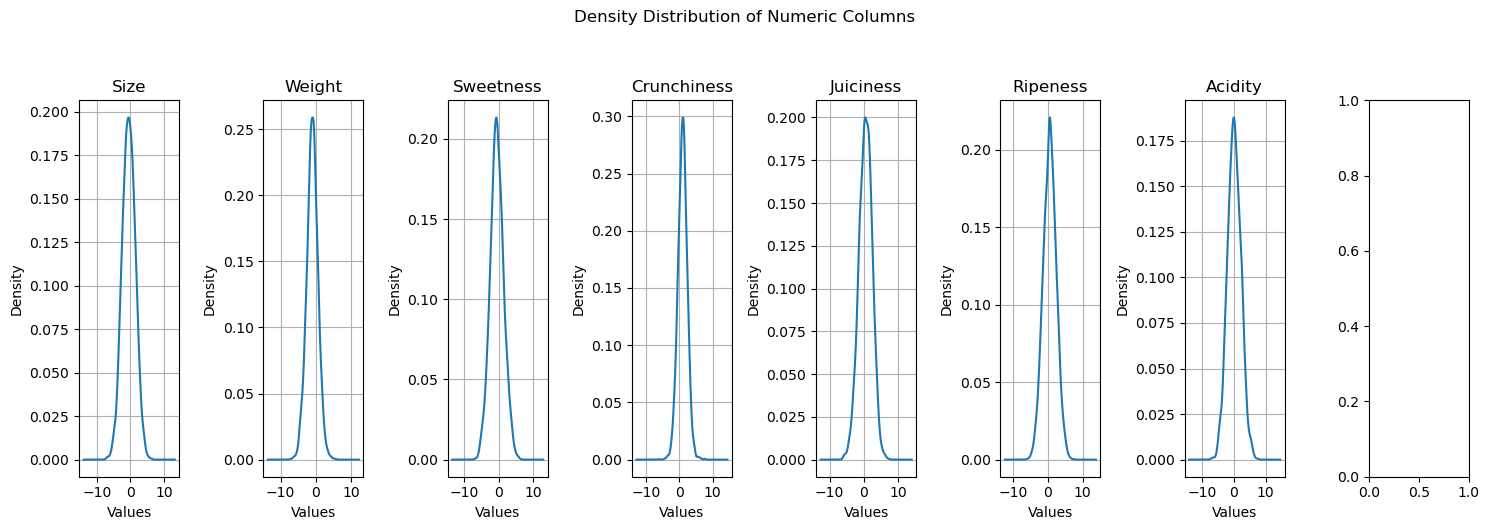

In [9]:
fig1, axes = plt.subplots(nrows=1, ncols=len(df_apple_orig.columns), figsize=(15, 5))
fig1.suptitle('Density Distribution of Numeric Columns', y=1.05)

for i, column in enumerate(df_apple_orig.drop('Quality', axis=1).columns):
    df_apple_orig.drop('Quality', axis=1)[column].plot(kind='kde', ax=axes[i])
    axes[i].set_title(column)
    axes[i].set_xlabel('Values')
    axes[i].set_ylabel('Density')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

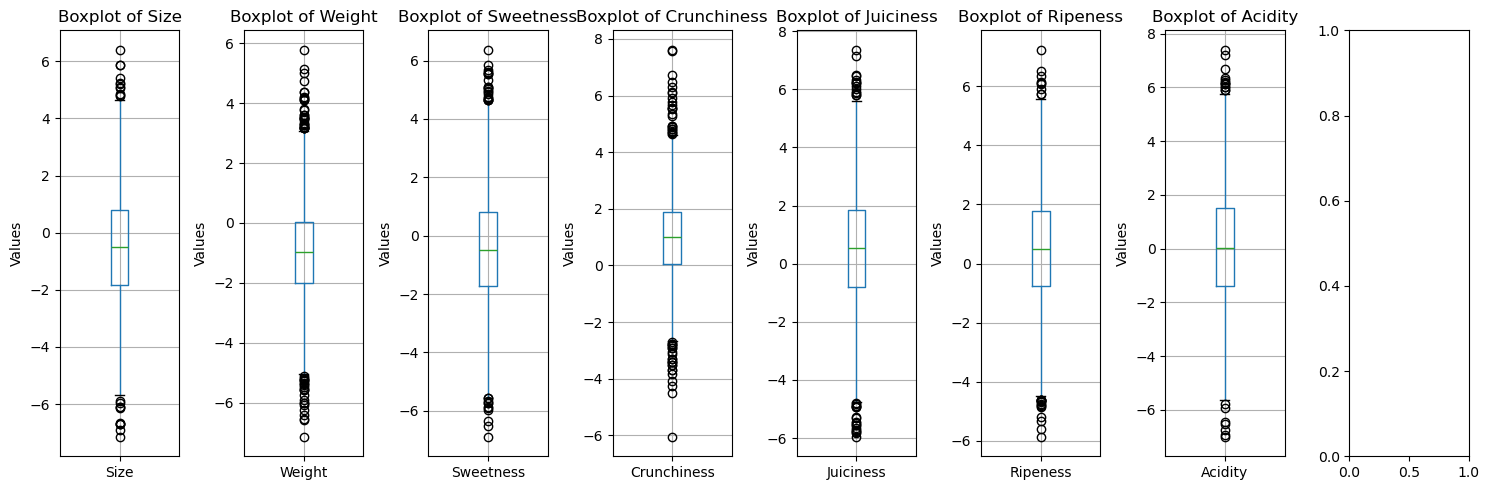

In [10]:
# Plot boxplots for each predictor
fig2, axes = plt.subplots(nrows=1, ncols=len(df_apple_orig.columns), figsize=(15, 5))

for i, column in enumerate(df_apple_orig.drop('Quality', axis=1).columns):
    df_apple_orig.boxplot(column=column, ax=axes[i])
    axes[i].set_title('Boxplot of ' + column)
    axes[i].set_ylabel('Values')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

### Checking for Multicollinearity

In [11]:
X = add_constant(df_apple_orig.drop('Quality', axis=1)) #remove target variable

# Create a DataFrame that will hold the feature names and their VIFs
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns

# Calculate VIF for each feature
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)

       Feature       VIF
0        const  2.498135
1         Size  1.413203
2       Weight  1.347796
3    Sweetness  1.476987
4  Crunchiness  1.218052
5    Juiciness  1.219475
6     Ripeness  1.477834
7      Acidity  1.172115


## Model 1: Binary Logistic Regression

In [12]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.feature_selection import RFECV

In [13]:
#Create copy of data for logistic reg model
df_apple_log = df_apple_orig.copy()

In [14]:
#Encoding Target variable:
label_encoder = LabelEncoder()
df_apple_log['Quality'] = label_encoder.fit_transform(df_apple_log['Quality'])

In [15]:
# Split data into features and target variable
X = df_apple_log.drop('Quality', axis=1)
y = df_apple_log['Quality']

#Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

In [16]:
#Train logistic regression model:
logistic_model = LogisticRegression(solver='liblinear', max_iter=1000) #liblinear since this is a small dataset
logistic_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [17]:
# Predictions and evaluation
y_pred = logistic_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

In [18]:
accuracy, conf_matrix

(0.74625,
 array([[298, 108],
        [ 95, 299]], dtype=int64))

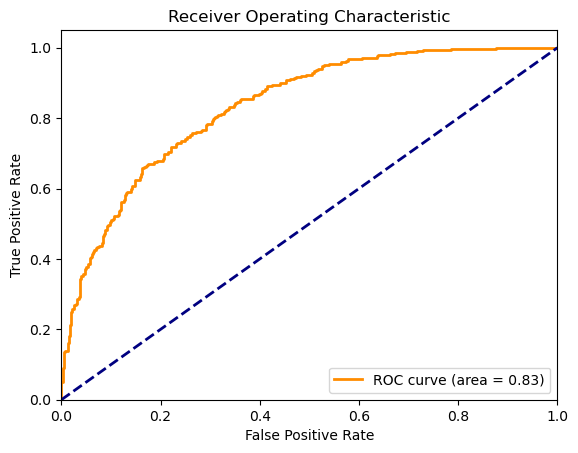

In [19]:
#get roc curve
y_scores = logistic_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

#plot
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('AQ_MOD1_LR.png')
plt.show()

In [20]:
#create classification report
report_df1 = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
report_df1

,precision,recall,f1-score,support
0,0.758270,0.733990,0.745932,406.00000
1,0.734644,0.758883,0.746567,394.00000
accuracy,0.746250,0.746250,0.746250,0.74625
macro avg,0.746457,0.746437,0.746250,800.00000
weighted avg,0.746634,0.746250,0.746245,800.00000


### Removing outliers
Logistic Regression is sensitive to outliers, as such they will be removed. After removal, only 2.425% of the data was dropped. 

In [21]:
#Calculate Z-scores of the data
z_scores = np.abs(stats.zscore(df_apple_orig.select_dtypes(include=[np.number])))
outliers = np.where(z_scores > 3) #identify rows with a z-score greater than 3


df_apple_OL_rem = df_apple_orig.copy().drop(index=set(outliers[0]))

# Check how much data remains after removing outliers
remaining_data_percentage = (len(df_apple_OL_rem) / len(df_apple_orig)) * 100
print(f"{remaining_data_percentage}% of the data remains")

97.575% of the data remains


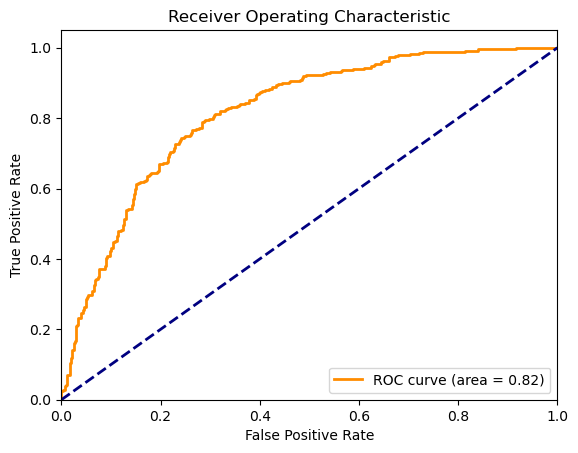

In [22]:
# Re-encode the 'Quality' column
df_apple_OL_rem['Quality'] = label_encoder.fit_transform(df_apple_OL_rem['Quality'])

# Split data into features and target variable
X = df_apple_OL_rem.drop('Quality', axis=1)
y = df_apple_OL_rem['Quality']

#Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

#Train logistic regression model:
logistic_model = LogisticRegression(solver='liblinear', max_iter=1000) #liblinear since this is a small dataset
logistic_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = logistic_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

#get roc curve
y_scores = logistic_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

#plot
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [23]:
accuracy, conf_matrix

(0.7464788732394366,
 array([[302, 108],
        [ 90, 281]], dtype=int64))

In [24]:
#create classification report
report_df2 = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
report_df2

,precision,recall,f1-score,support
0,0.770408,0.736585,0.753117,410.000000
1,0.722365,0.757412,0.739474,371.000000
accuracy,0.746479,0.746479,0.746479,0.746479
macro avg,0.746387,0.746999,0.746295,781.000000
weighted avg,0.747586,0.746479,0.746636,781.000000


## Model 2: K-nearest Neighbors

In [25]:
from sklearn.neighbors import KNeighborsClassifier

In [26]:
#Define a range of k values to try
k_values = range(1, 26)
# Lists to store performance metrics for each k
accuracy_scores = []
f1_scores = []
sensitivity_scores = []
auc_scores = []

In [27]:
#Loop over k_values to find the best performing k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    # Compute performance metrics
    conf_matrix = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = report['weighted avg']['f1-score']
    sensitivity = report['1']['recall']
    
    # Compute ROC curve and AUC for each k
    y_pred_proba = knn.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Store metrics
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    sensitivity_scores.append(sensitivity)
    auc_scores.append(roc_auc)

In [28]:
# Identify the best performing k based on highest accuracy
best_k = k_values[accuracy_scores.index(max(accuracy_scores))]
print(f"The best k value is: {best_k}")

The best k value is: 7


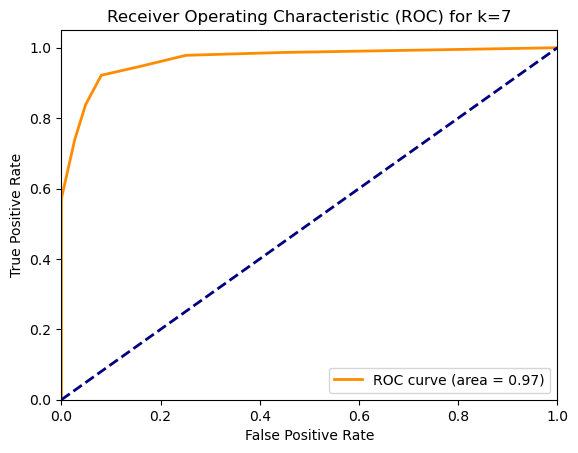

In [29]:
#get roc curve
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train, y_train)
y_pred_best_proba = knn_best.predict_proba(X_test)[:, 1]
fpr_best, tpr_best, _ = roc_curve(y_test, y_pred_best_proba)
roc_auc_best = auc(fpr_best, tpr_best)

#plot
plt.figure()
plt.plot(fpr_best, tpr_best, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_best)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for k=%d' % best_k)
plt.legend(loc="lower right")
plt.savefig('AQ_MOD1_KNN.png')
plt.show()

In [30]:
best_k, max(accuracy_scores), max(f1_scores), max(sensitivity_scores), max(auc_scores)
print(f"The best k value is {best_k}, which results in an accuracy score of {max(accuracy_scores)}, and a max F1-score of {max(f1_scores)}")

The best k value is 7, which results in an accuracy score of 0.9206145966709347, and a max F1-score of 0.9206328541034934


In [31]:
performance_scores_df = pd.DataFrame({
    'k': k_values,
    'Accuracy': accuracy_scores,
    'F1 Score': f1_scores,
    'Sensitivity': sensitivity_scores,
    'AUC': auc_scores
})

performance_scores_df

,k,Accuracy,F1 Score,Sensitivity,AUC
0,1,0.892446,0.892431,0.884097,0.892049
1,2,0.879641,0.878695,0.803235,0.932736
2,3,0.896287,0.896293,0.892183,0.944974
3,4,0.893726,0.893271,0.840970,0.955069
4,5,0.907810,0.907784,0.897574,0.960016
5,6,0.902689,0.902473,0.867925,0.963464
6,7,0.920615,0.920633,0.921833,0.966564
7,8,0.918054,0.917935,0.892183,0.967869
8,9,0.919334,0.919357,0.921833,0.966606
9,10,0.907810,0.907718,0.886792,0.966120


# Dataset 2 - Global Sales Records
Link: https://excelbianalytics.com/wp/downloads-18-sample-csv-files-data-sets-for-testing-sales/

In [32]:
df100k_orig = pd.read_csv("data2/100000 Sales Records.csv").drop('Order ID', axis=1)
df100k_orig.head(2)

,Region,Country,Item Type,Sales Channel,Order Priority,Order Date,Ship Date,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit
0,Middle East and North Africa,Azerbaijan,Snacks,Online,C,10/8/2014,10/23/2014,934,152.58,97.44,142509.72,91008.96,51500.76
1,Central America and the Caribbean,Panama,Cosmetics,Offline,L,2/22/2015,2/27/2015,4551,437.20,263.33,1989697.20,1198414.83,791282.37


### Checking for missing values and column datatypes

In [33]:
df100k=df100k_orig.copy()

#Get Column info
df100k.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Region          100000 non-null  object 
 1   Country         100000 non-null  object 
 2   Item Type       100000 non-null  object 
 3   Sales Channel   100000 non-null  object 
 4   Order Priority  100000 non-null  object 
 5   Order Date      100000 non-null  object 
 6   Ship Date       100000 non-null  object 
 7   Units Sold      100000 non-null  int64  
 8   Unit Price      100000 non-null  float64
 9   Unit Cost       100000 non-null  float64
 10  Total Revenue   100000 non-null  float64
 11  Total Cost      100000 non-null  float64
 12  Total Profit    100000 non-null  float64
dtypes: float64(5), int64(1), object(7)
memory usage: 9.9+ MB


### Checking For Class Imbalance

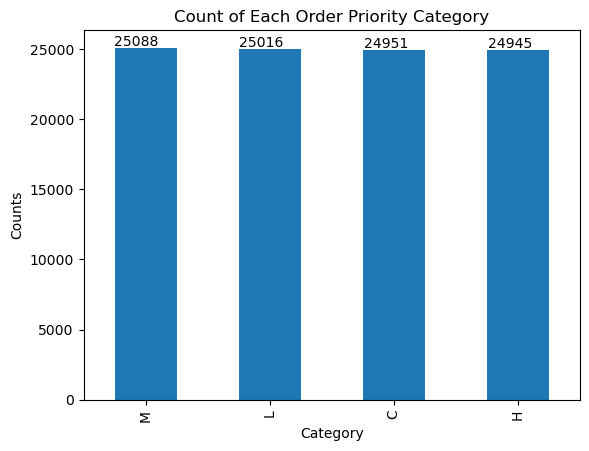

In [34]:
# Counting the occurrences of each category
category_counts = df100k['Order Priority'].value_counts()

# Plotting
ax = category_counts.plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Counts')
plt.title('Count of Each Order Priority Category')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

### Checking distribution of all Numerical Predictor Variables

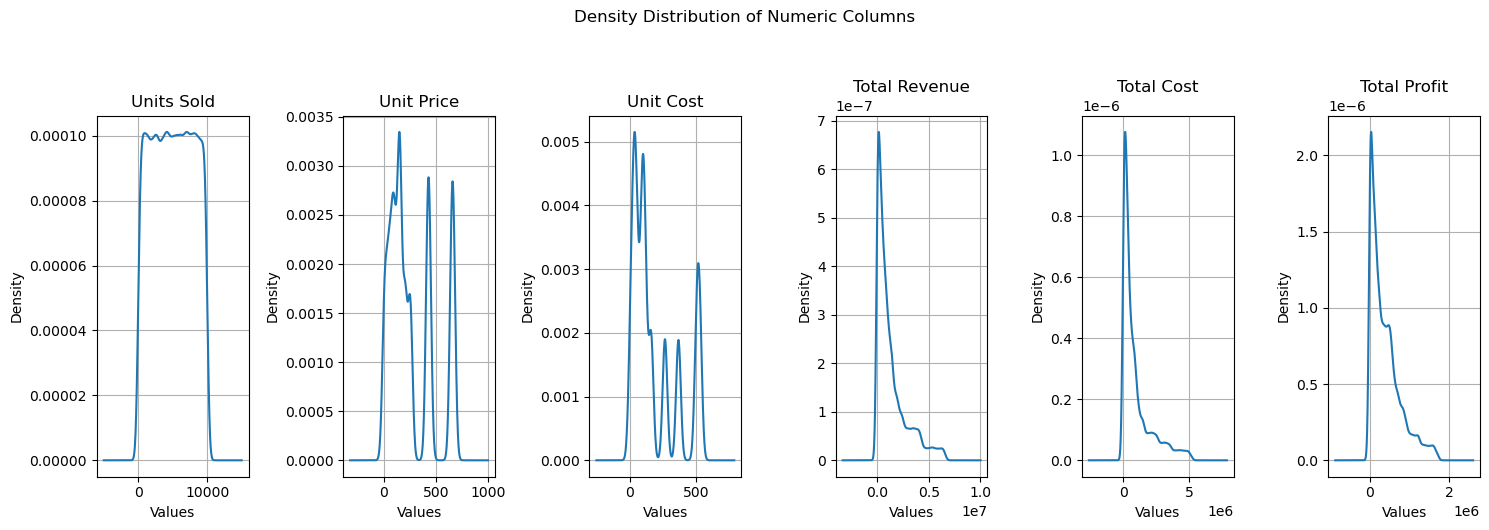

In [35]:
mask = df100k.dtypes.apply(lambda x: np.issubdtype(x, np.number))
numeric_df_using_mask = df100k.loc[:, mask]

fig3, axes = plt.subplots(nrows=1, ncols=len(numeric_df_using_mask.columns), figsize=(15, 5))
fig3.suptitle('Density Distribution of Numeric Columns', y=1.05)

for i, column in enumerate(numeric_df_using_mask.columns):
    df100k[column].plot(kind='kde', ax=axes[i])
    axes[i].set_title(column)
    axes[i].set_xlabel('Values')
    axes[i].set_ylabel('Density')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

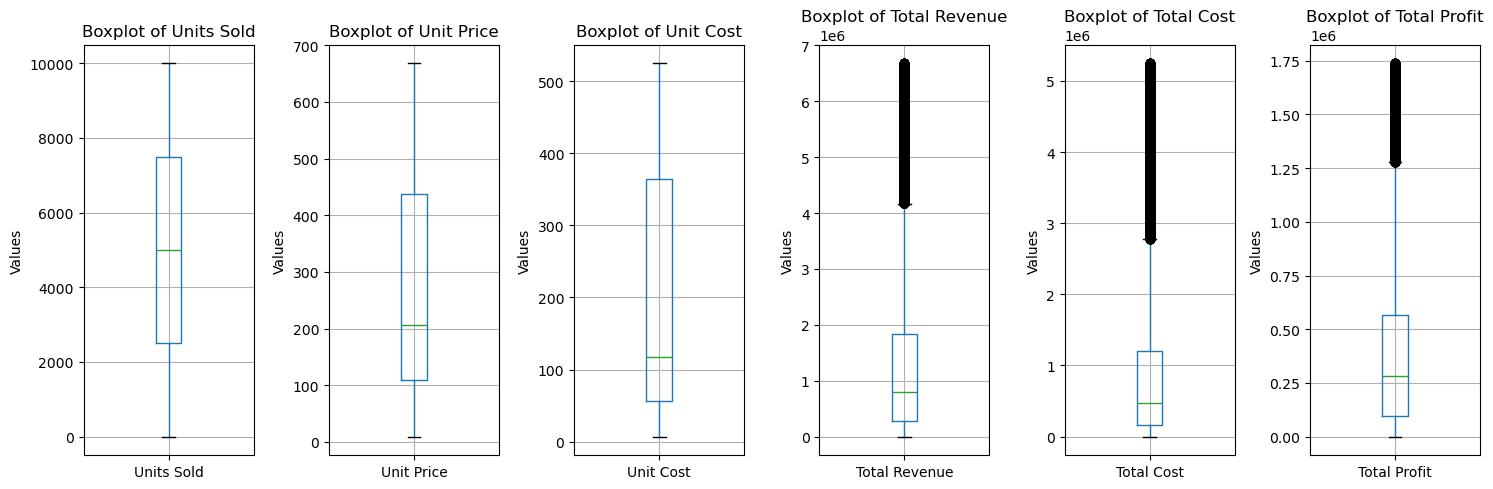

In [36]:
# Plot boxplots for each predictor
fig4, axes = plt.subplots(nrows=1, ncols=len(numeric_df_using_mask.columns), figsize=(15, 5))

for i, column in enumerate(numeric_df_using_mask.columns):
    numeric_df_using_mask.boxplot(column=column, ax=axes[i])
    axes[i].set_title('Boxplot of ' + column)
    axes[i].set_ylabel('Values')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

In [37]:
#Power transform to normalize numeric columns
pt = PowerTransformer(method='yeo-johnson')
df100k_transformed = df100k.copy()
columns_to_transform = ['Units Sold', 'Unit Price', 'Unit Cost', 'Total Revenue', 'Total Cost', 'Total Profit']
df100k_transformed[columns_to_transform] = pt.fit_transform(df100k_transformed[columns_to_transform])

### Checking for Multicollinearity

In [38]:
X = add_constant(numeric_df_using_mask) #constant ensures that the regression model has an intercept

# Create a DataFrame that will hold the feature names and their VIFs
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns

# Calculate VIF for each feature
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)

         Feature         VIF
0          const   12.971319
1     Units Sold    3.255320
2     Unit Price  144.726533
3      Unit Cost  144.858623
4  Total Revenue         inf
5     Total Cost         inf
6   Total Profit         inf


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [39]:
# Define the columns to drop
columns_to_drop = ["Total Revenue", "Total Cost", "Unit Price", "Order Date", "Ship Date"]
data_dropped = df100k_transformed.drop(columns=columns_to_drop)

mask = data_dropped.dtypes.apply(lambda x: np.issubdtype(x, np.number))
numeric_df_using_mask = data_dropped.loc[:, mask]

X = add_constant(numeric_df_using_mask)
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns

# Calculate VIF for each feature
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)

        Feature       VIF
0         const  1.000000
1    Units Sold  2.836554
2     Unit Cost  2.733870
3  Total Profit  4.583705


In [40]:
data_dropped.head(5)

,Region,Country,Item Type,Sales Channel,Order Priority,Units Sold,Unit Cost,Total Profit
0,Middle East and North Africa,Azerbaijan,Snacks,Online,C,-1.496749,-0.200921,-1.046576
1,Central America and the Caribbean,Panama,Cosmetics,Offline,L,-0.049141,0.725846,1.082608
2,Sub-Saharan Africa,Sao Tome and Principe,Fruits,Offline,M,1.552072,-1.874118,-1.382252
3,Sub-Saharan Africa,Sao Tome and Principe,Personal Care,Online,M,1.317985,-0.630479,-0.108566
4,Central America and the Caribbean,Belize,Household,Offline,H,0.371677,1.438434,1.326568


## Model 3: Multinomial Logistic Regression

In [41]:
X = data_dropped.drop(['Order Priority'], axis=1)
y = data_dropped['Order Priority']

encoder = OneHotEncoder(sparse=False)
X_encoded = pd.DataFrame(encoder.fit_transform(X.select_dtypes(include=['object'])))
X_encoded.columns = encoder.get_feature_names_out(X.select_dtypes(include=['object']).columns)

# Dropping original categorical columns and concatenating encoded columns
X = X.drop(X.select_dtypes(include=['object']).columns, axis=1)
X = pd.concat([X, X_encoded], axis=1)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [42]:
# Training the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

# Predicting the Order Priority on the test set
y_pred = model.predict(X_test)

# Evaluating the model's performance
accuracy = accuracy_score(y_test, y_pred)

accuracy

0.25055

In [43]:
df100k_mlr = df100k_orig.copy()
df100k_mlr.head()

,Region,Country,Item Type,Sales Channel,Order Priority,Order Date,Ship Date,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit
0,Middle East and North Africa,Azerbaijan,Snacks,Online,C,10/8/2014,10/23/2014,934,152.58,97.44,142509.72,91008.96,51500.76
1,Central America and the Caribbean,Panama,Cosmetics,Offline,L,2/22/2015,2/27/2015,4551,437.20,263.33,1989697.20,1198414.83,791282.37
2,Sub-Saharan Africa,Sao Tome and Principe,Fruits,Offline,M,12/9/2015,1/18/2016,9986,9.33,6.92,93169.38,69103.12,24066.26
3,Sub-Saharan Africa,Sao Tome and Principe,Personal Care,Online,M,9/17/2014,10/12/2014,9118,81.73,56.67,745214.14,516717.06,228497.08
4,Central America and the Caribbean,Belize,Household,Offline,H,2/4/2010,3/5/2010,5858,668.27,502.54,3914725.66,2943879.32,970846.34


In [44]:
# Preprocessing
X = df100k_mlr.drop(['Order Priority', 'Order Date', 'Ship Date'], axis=1)
y = df100k_mlr['Order Priority']
encoder = OneHotEncoder(sparse=False)
X_encoded = pd.DataFrame(encoder.fit_transform(X.select_dtypes(include=['object'])))
X_encoded.columns = encoder.get_feature_names_out(X.select_dtypes(include=['object']).columns)
X = X.drop(X.select_dtypes(include=['object']).columns, axis=1)
X = pd.concat([X, X_encoded], axis=1)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [45]:
# RFECV with Logistic Regression
rfecv = RFECV(estimator=LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000),
              step=1,
              cv=StratifiedKFold(5),
              scoring='accuracy')
rfecv.fit(X_train_scaled, y_train)

# Predicting and evaluating on the test set
y_pred = rfecv.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
optimal_features = rfecv.n_features_

print(f"Accuracy: {accuracy}")
print(f"Optimal number of features: {optimal_features}")

Accuracy: 0.24985
Optimal number of features: 10


In [46]:
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

In [47]:
report_df3 = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
report_df3

,precision,recall,f1-score,support
C,0.232759,0.010748,0.020548,5024.00000
H,0.253333,0.372773,0.301661,4995.00000
L,0.248107,0.255958,0.251972,4993.00000
M,0.248108,0.361468,0.294247,4988.00000
accuracy,0.249850,0.249850,0.249850,0.24985
macro avg,0.245577,0.250237,0.217107,20000.00000
weighted avg,0.245557,0.249850,0.216791,20000.00000


## Model 4: KNN

In [70]:
#Data preprocessing
df100k_knn= df100k_orig.copy()
df100k_knn = df100k_knn.drop(["Order Date", "Ship Date"], axis=1)

#Identify numerical and categorical columns
numerical_cols_knn = df100k_knn.select_dtypes(include=['float64', 'int64']).columns
categorical_cols_knn = df100k_knn.select_dtypes(include=['object']).columns.drop("Order Priority")

In [71]:
df100k_knn.head(2)

,Region,Country,Item Type,Sales Channel,Order Priority,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit
0,Middle East and North Africa,Azerbaijan,Snacks,Online,C,934,152.58,97.44,142509.72,91008.96,51500.76
1,Central America and the Caribbean,Panama,Cosmetics,Offline,L,4551,437.20,263.33,1989697.20,1198414.83,791282.37


In [72]:
# Splitting the data into features and target based on the corrected understanding
X_knn = df100k_knn.drop(['Order Priority'], axis=1)  # Excluding 'Order Priority' and 'Order ID'
y_knn = df100k_knn['Order Priority']  # 'Order Priority' is the target variable

In [73]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_knn, y_knn, test_size=0.2, random_state=40)

In [74]:
# Defining the preprocessing for numerical and categorical data
numerical_preprocessor = Pipeline(steps=[
    ('power_transformer', PowerTransformer()),
    ('scaler', StandardScaler())
])

categorical_preprocessor = OneHotEncoder(handle_unknown='ignore')

# Combining preprocessors into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_preprocessor, numerical_cols_knn),
        ('cat', categorical_preprocessor, categorical_cols_knn)
    ])

In [75]:
# Creating the KNN model pipeline
knn_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

# Training the KNN model
knn_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('power_transformer',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Units Sold', 'Unit Price', 'Unit Cost', 'Total Revenue', 'Total Cost',
       'Total Profit'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Region', 'Country', 'Item Type', 'Sales Channel'], dtype='object'))])),
                ('classifier', KNeighborsClassifier())])

In [87]:
#Define a range of k values to try
k_values = range(1, 26)

#Lists to store performance metrics for each k
results = []

#Loop over k_values to find the best performing k
for k in k_values:
    knn_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier(n_neighbors=k))
    ])
    
    knn_model.fit(X_train, y_train)
    y_pred = knn_model.predict(X_test)
    
    # Compute performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    f1 = report['weighted avg']['f1-score']
    
    # Store metrics
    results.append((k, accuracy, f1))

# Identify the best performing k based on highest accuracy
best_k = k_values[accuracy_scores.index(max(accuracy_scores))]
print(f"The best k value is: {best_k}")

The best k value is: 5


In [95]:
knn_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier(n_neighbors=5))
    ])
    
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)
    
# Compute performance metrics
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
f1 = report['weighted avg']['f1-score']

In [96]:
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

In [97]:
report_df3 = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
report_df3

,precision,recall,f1-score,support
C,0.270852,0.360669,0.309373,5024.00000
H,0.271361,0.300100,0.285008,4995.00000
L,0.273924,0.245944,0.259181,4993.00000
M,0.276113,0.182839,0.219998,4988.00000
accuracy,0.272550,0.272550,0.272550,0.27255
macro avg,0.273062,0.272388,0.268390,20000.00000
weighted avg,0.273058,0.272550,0.268467,20000.00000
